In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")

TARGET = "default.payment.next.month"
X = df.drop(columns=[TARGET])
y = df[TARGET]


In [3]:
def feature_engineering(df):
    df = df.copy()

    bill_cols = [f"BILL_AMT{i}" for i in range(1, 7)]
    pay_cols = [f"PAY_AMT{i}" for i in range(1, 7)]
    delay_cols = ["PAY_0"] + [f"PAY_{i}" for i in range(2, 7)]

    # Average bill and payment
    df["avg_bill_amt"] = df[bill_cols].mean(axis=1)
    df["avg_pay_amt"] = df[pay_cols].mean(axis=1)

    # Credit utilization
    df["credit_utilization"] = df["avg_bill_amt"] / (df["LIMIT_BAL"] + 1)

    # Payment ratios
    for i in range(1, 7):
        df[f"pay_ratio_{i}"] = df[f"PAY_AMT{i}"] / (df[f"BILL_AMT{i}"] + 1)

    # Delay behavior
    df["max_delay"] = df[delay_cols].max(axis=1)
    df["mean_delay"] = df[delay_cols].mean(axis=1)
    df["delay_count"] = (df[delay_cols] > 0).sum(axis=1)

    # Bill and payment trends (slope)
    df["bill_trend"] = np.polyfit(range(6), df[bill_cols].values.T, 1)[0]
    df["pay_trend"] = np.polyfit(range(6), df[pay_cols].values.T, 1)[0]

    return df


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [5]:
# After feature engineering
X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)

# 1. Remove inf
X_train_fe.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_fe.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Clip extreme values
# X_train_fe = X_train_fe.clip(-10, 10)
# X_test_fe = X_test_fe.clip(-10, 10)

# 3. Impute missing values
median_vals = X_train_fe.median()
X_train_fe.fillna(median_vals, inplace=True)
X_test_fe.fillna(median_vals, inplace=True)

feature_names = X_train_fe.columns.tolist()

# 4. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fe)
X_test_scaled = scaler.transform(X_test_fe)


In [6]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            "max_depth": [4, 6, 8, None],
            "min_samples_leaf": [5, 20, 50]
        }
    ),

    "RandomForest": (
        RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ),
        {
            "max_depth": [6, 10, None],
            "min_samples_leaf": [5, 20],
            "max_features": ["sqrt", "log2"]
        }
    ),

    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "learning_rate": [0.05, 0.1],
            "n_estimators": [200, 300],
            "max_depth": [3, 5]
        }
    ),

    "XGBoost": (
        XGBClassifier(
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ),
        {
            "n_estimators": [300, 500],
            "max_depth": [4, 6],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    )
}


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, top_n=20, title="Feature Importance"):
    """
    Plot feature importance for tree-based models
    """
    importances = model.feature_importances_

    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # Print top features
    print(f"\nTop {top_n} Features:")
    print(fi_df.head(top_n))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(
        fi_df.head(top_n)["feature"][::-1],
        fi_df.head(top_n)["importance"][::-1]
    )
    plt.xlabel("Importance Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return fi_df



===== TRAINING DecisionTree =====
Best Params: {'max_depth': 6, 'min_samples_leaf': 50}
ROC-AUC: 0.7605383811925391
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.34      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000

Confusion Matrix:
[[4453  220]
 [ 871  456]]

Top 15 Features:
               feature  importance
6                PAY_0    0.640753
35         delay_count    0.208780
25         avg_pay_amt    0.032343
1            LIMIT_BAL    0.022785
26  credit_utilization    0.019980
12           BILL_AMT1    0.011354
0                   ID    0.007751
19            PAY_AMT2    0.007435
36          bill_trend    0.007161
28         pay_ratio_2    0.006193
13           BILL_AMT2    0.005989
8                PAY_3    0.005432
5              

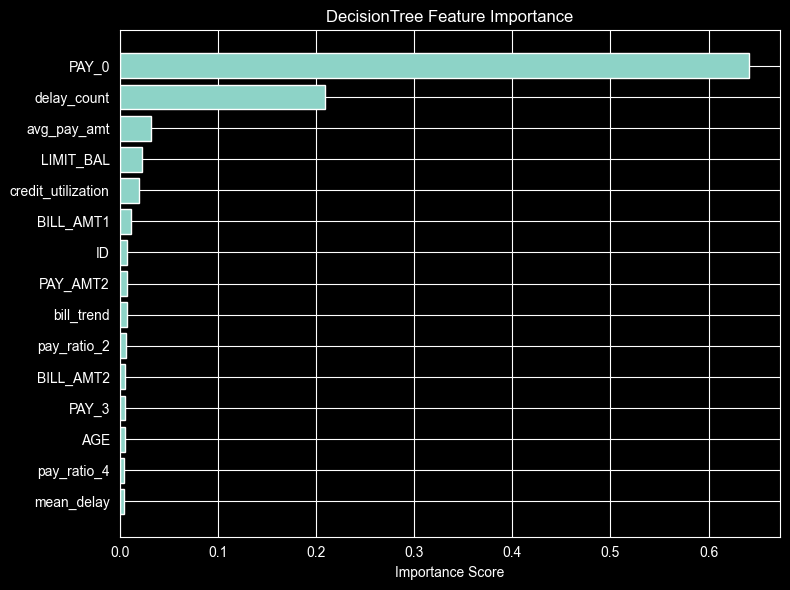


===== TRAINING RandomForest =====
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20}
ROC-AUC: 0.7779541630792487
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Confusion Matrix:
[[4418  255]
 [ 840  487]]

Top 15 Features:
               feature  importance
6                PAY_0    0.151802
33           max_delay    0.093844
34          mean_delay    0.091754
35         delay_count    0.077563
7                PAY_2    0.049261
26  credit_utilization    0.029129
25         avg_pay_amt    0.027140
8                PAY_3    0.024999
1            LIMIT_BAL    0.021403
36          bill_trend    0.020946
24        avg_bill_amt    0.020910
9                PAY_4 

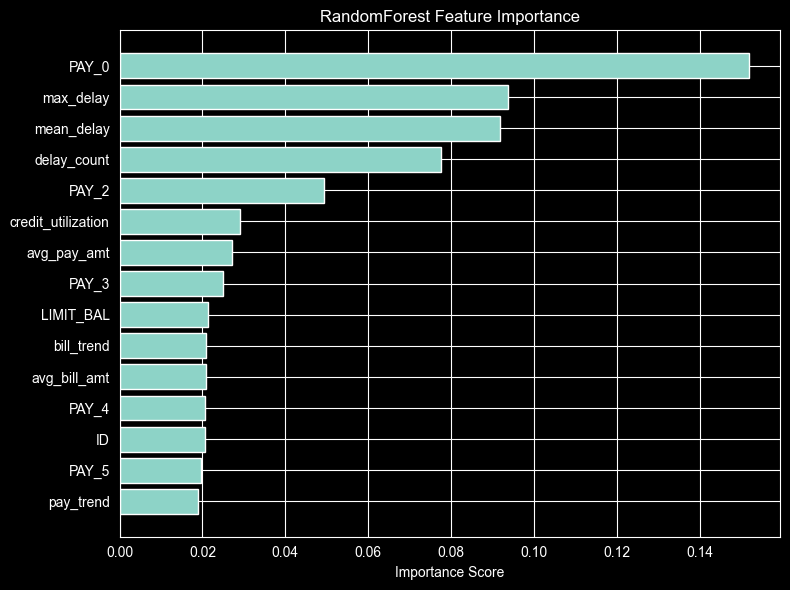


===== TRAINING GradientBoosting =====
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
ROC-AUC: 0.7835329574520273
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Confusion Matrix:
[[4438  235]
 [ 842  485]]

Top 15 Features:
               feature  importance
6                PAY_0    0.528877
33           max_delay    0.114372
35         delay_count    0.092114
34          mean_delay    0.041894
25         avg_pay_amt    0.024705
12           BILL_AMT1    0.021261
26  credit_utilization    0.021164
24        avg_bill_amt    0.020219
1            LIMIT_BAL    0.017088
36          bill_trend    0.011754
0                   ID    0.009663
19            PAY_AMT2    

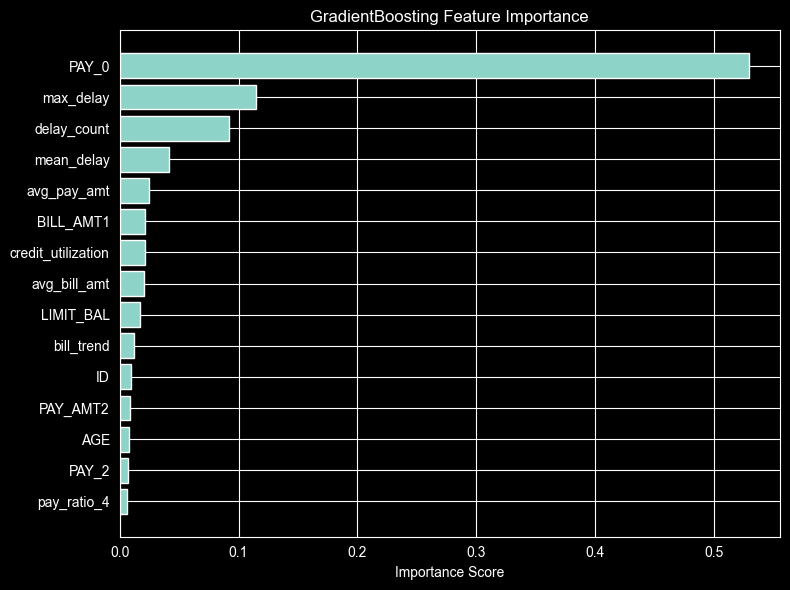


===== TRAINING XGBoost =====
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
ROC-AUC: 0.7793258616132599
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Confusion Matrix:
[[4419  254]
 [ 838  489]]

Top 15 Features:
               feature  importance
33           max_delay    0.334290
6                PAY_0    0.217313
35         delay_count    0.048645
34          mean_delay    0.023476
24        avg_bill_amt    0.019714
25         avg_pay_amt    0.018725
7                PAY_2    0.015392
8                PAY_3    0.015228
19            PAY_AMT2    0.015081
12           BILL_AMT1    0.014192
1            LIMIT_BAL    0

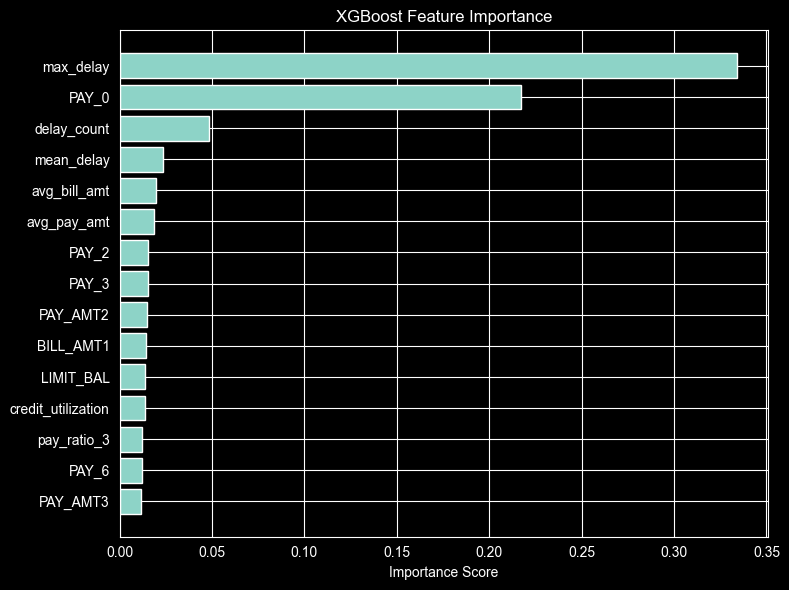

In [8]:
results = {}

for name, (model, param_grid) in models.items():
    print(f"\n===== TRAINING {name} =====")

    grid = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1
    )

    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    results[name] = roc_auc_score(y_test, y_prob)

    print("Best Params:", grid.best_params_)
    print("ROC-AUC:", results[name])
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    plot_feature_importance(
    model=best_model,
    feature_names=feature_names,
    top_n=15,
    title=f"{name} Feature Importance"
)
